In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import ternary
from ternary.helpers import simplex_iterator
from citrination_client import CitrinationClient
import os
import pymatgen as mg
import pandas as pd

## Make heatmap of ML FWHM predictions

In [2]:
plotdir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines\\Research\\MIDDMI\\TCO\\scripts\\XRD_analysis\\plots')

def formula_from_tuple(tup,Y=0,scale=1,Ba=0.9):
    cfz = 1 - Y
    Co = tup[0]*cfz/scale
    Fe = tup[1]*cfz/scale
    Zr = tup[2]*cfz/scale
    #Y = 1 - np.sum(tup)/scale
    formula = 'Ba{}Co{}Fe{}Zr{}Y{}O3'.format(Ba,Co,Fe,Zr,Y)
    return formula

def rescale_ticks(tax,new_scale,multiple,axis='lbr',**kwargs): #for redrawing ticks based on desired scale - doesn't scale actual data
    scale = tax._scale
    ticks = np.arange(0,new_scale + multiple,multiple)
    locations = np.arange(0,scale + multiple*scale/new_scale,multiple*scale/new_scale)
    tax.ticks(ticks=list(ticks), locations=list(locations),axis=axis,**kwargs)

In [3]:
client = CitrinationClient(os.environ['CITRINATION_API_KEY'],'https://citrination.com')
view_id = '4209'

scale = 25
tuples = []
#scaled_tup = []
inp_dict = []

for tup in simplex_iterator(scale):
    f = formula_from_tuple(tup,scale=scale,Y=0.1)
    tuples.append(tup)
    #scaled_tup.append(tuple(int(x*100/scale) for x in tup))
    inp_dict.append({'formula':f})


In [5]:
results = client.predict(view_id,inp_dict)

In [10]:
[r for r in results[0].all_keys() if r.find('Property')>-1]
help(results[0].get_value('Property FWHM of 110 peak'))

Help on PredictedValue in module citrination_client.models.predicted_value object:

class PredictedValue(builtins.object)
 |  The value/loss output from a prediction.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, key, value, loss=None)
 |      Constructor.
 |      
 |      :param key: The descriptor key for the prediction
 |      :type key: str
 |      :param value: The predicted value
 |      :type value: str or float
 |      :param loss: The loss for the prediction
 |      :type loss: float
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)
 |  
 |  key
 |  
 |  loss
 |  
 |  value



In [18]:
results[0].get_value('Property FWHM of 110 peak').value

0.5516353325925917

In [4]:
cand = client.predict(view_id,inp_dict)['candidates']
fwhm = [c['Property FWHM of 110 peak'][0] for c in cand]

TypeError: list indices must be integers or slices, not str

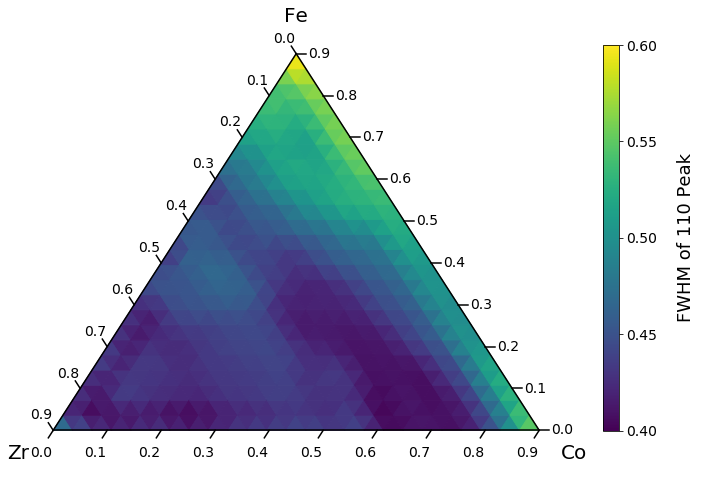

In [87]:
d = dict(zip([t[0:2] for t in tuples],fwhm))

fig, tax = ternary.figure(scale=scale)
fig.set_size_inches(11,8)

tax.heatmap(d,style='triangular',colorbar=False)
rescale_ticks(tax,new_scale=0.9,multiple=0.1,tick_formats='%.1f',offset=0.02,fontsize=14)
tax.boundary()
tax.ax.axis('off')
tax.right_corner_label('Co',fontsize=20)
tax.top_corner_label('Fe',fontsize=20)
tax.left_corner_label('Zr',fontsize=20)

#add formattable colorbar
vmin=0.4
vmax=0.6
cmap=plt.cm.viridis
cbaxes = fig.add_axes([0.85,0.2,0.02,0.67]) #[left, bottom, width, height]
#code from colormapping.colorbar_hack
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=tax.ax, cax = cbaxes, ticks=np.arange(vmin,vmax+0.05,0.05))
cb.set_label('FWHM of 110 Peak', fontsize=18, labelpad=20)
cb.ax.tick_params(labelsize=14)
fig.subplots_adjust(right=0.8)

tax._redraw_labels()

plt.savefig(os.path.join(plotdir,'ML_heatmap_180625.png'),dpi=500)

## Make plot of experimental FWHM data

In [54]:
datadir = os.path.join(os.environ['HOME'],'OneDrive - Colorado School of Mines\\Research\\MIDDMI\\TCO\\XRD_data')
proc = 'processed'
procdir = os.path.join(datadir,proc)
os.chdir(procdir)

"Load samples from CSVs"
os.chdir(procdir)
procdat = pd.DataFrame()

for lib in next(os.walk(procdir))[1]:
    os.chdir(lib)
    pfname = '_'.join([lib,'AllVar.csv'])
        
    if os.path.exists(pfname):
        #read processed file
        proc = pd.read_csv(pfname)
        procdat = procdat.append(proc,ignore_index=True)
    
    os.chdir(procdir)
    
Bsite = ['Co','Fe','Y','Zr']
compdat = pd.DataFrame(columns=['formula','Co','Fe','Y','Zr','fwhm_110','sample','structure','substrate'])
for i in procdat.index:
    try:
        comp = mg.Composition(procdat.loc[i,'FORMULA'])
        compdat.loc[i,'formula'] = procdat.loc[i,'FORMULA']
        compdat.loc[i,'fwhm_110'] = procdat.loc[i,'PROPERTY: FWHM of 110 peak ($^{\circ}$)']
        compdat.loc[i,'sample'] = procdat.loc[i,'IDENTIFIER: Sample number']
        #compdat.loc[i,'structure'] = procdat.loc[i,'PROPERTY: Structure']
        compdat.loc[i,'substrate'] = procdat.loc[i,'PREPARATION STEP DETAIL: Substrate']
        for el in Bsite:
            compdat.loc[i,el] = comp.get_el_amt_dict()[el]
    except Exception as err: #Sample 1256 has negative Fe amt, just ignore for now
        print('Index {}: {}'.format(i,err))
        pass
    
#check substrates - need to remove ITO/EXG
for s in compdat['substrate'].unique():
    sdf = compdat[compdat['substrate']==s]
    print('{}: {}'.format(s,len(sdf)))
    print(sdf['sample'].unique())



Index 2200: Amounts in Composition cannot be negative!
Index 2201: Amounts in Composition cannot be negative!
Index 2202: Amounts in Composition cannot be negative!
Index 2203: Amounts in Composition cannot be negative!
Index 2204: Amounts in Composition cannot be negative!
Index 2205: Amounts in Composition cannot be negative!
Index 2206: Amounts in Composition cannot be negative!
Index 2207: Amounts in Composition cannot be negative!
Index 2208: Amounts in Composition cannot be negative!
Index 2209: Amounts in Composition cannot be negative!
Index 2210: Amounts in Composition cannot be negative!
Index 2211: Amounts in Composition cannot be negative!
Index 2212: Amounts in Composition cannot be negative!
Index 2213: Amounts in Composition cannot be negative!
Index 2214: Amounts in Composition cannot be negative!
Index 2215: Amounts in Composition cannot be negative!
Index 2216: Amounts in Composition cannot be negative!
Index 2217: Amounts in Composition cannot be negative!
Index 2218

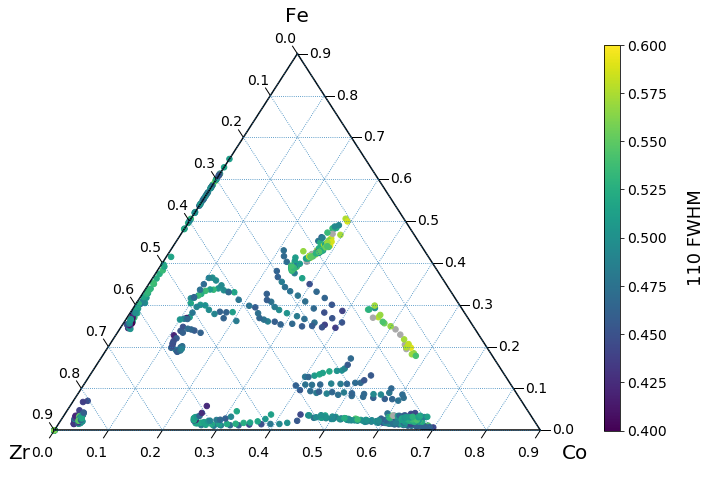

In [97]:
#compdat = compat.loc[procdat['substrate']!='ITO/EXG',:]

Y_min = 0.05
Y_max = 0.15

vmin=0.4
vmax=0.6

df = compdat[(compdat['Y']>=Y_min) & (compdat['Y']<=Y_max)]
df = df[df['substrate'].isin(['SiO2','EXG'])] #remove ITO/EXG
df = df.loc[pd.isnull(df['fwhm_110'])==False,:] #remove nans
points = df.loc[:,['Co','Fe','Zr']].values
colors = df.loc[:,'fwhm_110'].values#.replace(np.nan,10).values

ex_scale = 1 - 0.1 #point coords must sum to scale
#since each comp has different Y value, need to scale points to plot scale
ptsum = np.sum(points,axis=1)[np.newaxis].T
scaled_pts = points*ex_scale/ptsum

fig, tax = ternary.figure(scale=ex_scale)
fig.set_size_inches(11,8)

cmap = plt.cm.viridis
#cmap.set_over('darkgray',1.) #make nans grey
tax.scatter(scaled_pts,s=30,vmin=vmin,vmax=vmax,colormap=cmap,
            colorbar=False,c=colors)
tax.boundary()
#tax.clear_matplotlib_ticks()

tax.ticks(axis='lbr', linewidth=1, multiple=0.1, tick_formats='%.1f',offset=0.02,fontsize=14)
tax.gridlines(multiple=0.1,linewidth=0.8)

tax.right_corner_label('Co',fontsize=20)
tax.top_corner_label('Fe',fontsize=20)
tax.left_corner_label('Zr',fontsize=20)

#props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#tax.set_title('{0:.2f} $\leq$ Y < {1:.2f}'.format(Y_min,Y_max),fontsize=14,x=0.13,y=0.97, bbox=props)
tax._redraw_labels()
tax.ax.axis('off')


#add formattable colorbar

cmap=plt.cm.viridis
cbaxes = fig.add_axes([0.85,0.2,0.02,0.67]) #[left, bottom, width, height]
#code from colormapping.colorbar_hack
norm = plt.Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
cb = fig.colorbar(sm, ax=tax.ax, cax = cbaxes)
cb.set_label('110 FWHM', fontsize=18, labelpad=20)
cb.ax.tick_params(labelsize=14)
fig.subplots_adjust(right=0.8)

plt.savefig(os.path.join(plotdir,'0.1Y_ExpFWHM_forPoster.png'),dpi=400)

In [95]:
df['fwhm_110'].max()

0.86063427

In [116]:
tax._scale

25

In [ ]:
ternary